In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.chdir('/home/data/fhz/project/phmap_package')

import scanpy as sc
import phmap


   ____  _   __  __    _    ____  
  |  _ \| | |  \/  |  / \  |  _ \ 
  | |_) | |_| |\/| | / _ \ | |_) |
  |  __/|  _  |  | |/ ___ \|  __/ 
  |_|   |_| |_|  |_/_/   \_\_|    
                                  
  🔬 Multi-task Learning Framework for Cell Type Classifier
  🫁 pretrained model on pulmonary hypertension scRNA-seq data
    
🔖 Version: 0.1.1

🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 4090
   • Total memory: 23.6 GB
   • Compute capability: 8.9
   • CUDA version: 12.1



In [2]:
# Define the directory path where the h5 files are located
data_dir = "/home/data/fhz/project/reference_map_PH/data/GSE169471_PC"

# List all .h5 files in the specified directory
h5_filepaths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.h5')]

adata_list = []
sample_names = []
groups = []

if not h5_filepaths:
    print(f"No .h5 files found in {data_dir}. Skipping AnnData loading and merging.")
    adata_merged = None
else:
    print(f"Found {len(h5_filepaths)} .h5 files in {data_dir}.")
    # Read each .h5 file into an AnnData object and annotate sample / group from file name
    for file_path in sorted(h5_filepaths):
        fname = os.path.basename(file_path)
        print(f"Reading {fname}...")

        # Example file name:
        #   GSM5206784_SC31D_CON_56year_male_raw_feature_bc_matrix.h5
        # Rule:
        #   sample -> "GSM5206784_SC31D" (first two fields separated by '_')
        #   group  -> "CON" (third field separated by '_')
        basename = os.path.splitext(fname)[0]
        parts = basename.split('_')
        if len(parts) < 3:
            raise ValueError(f"Unexpected file name format: {fname}")

        sample_name = '_'.join(parts[:2])  # e.g. GSM5206784_SC31D
        group = parts[2]                   # e.g. CON / IPAH / CONlow / CONup

        # Read 10X h5 matrix
        adata = sc.read_10x_h5(file_path)

        # Ensure unique gene and cell indices within each AnnData
        adata.var_names_make_unique()
        adata.obs_names_make_unique()

        # Annotate cells with sample and group information
        adata.obs['sample'] = sample_name
        adata.obs['group'] = group

        adata_list.append(adata)
        sample_names.append(sample_name)
        groups.append(group)

Found 11 .h5 files in /home/data/fhz/project/reference_map_PH/data/GSE169471_PC.
Reading GSM5206779_SC17_IPAH_21year_male_raw_feature_bc_matrix.h5...
Reading GSM5206780_SC161_IPAH_50year_female_raw_feature_bc_matrix.h5...
Reading GSM5206781_SC207_IPAH_36year_female_raw_feature_bc_matrix.h5...
Reading GSM5206782_SC14_CON_76year_male_raw_feature_bc_matrix.h5...
Reading GSM5206783_SC31_CON_56year_male_raw_feature_bc_matrix.h5...
Reading GSM5206784_SC31D_CON_56year_male_raw_feature_bc_matrix.h5...
Reading GSM5206785_SC45_CON_55year_male_raw_feature_bc_matrix.h5...
Reading GSM5206786_SC56_CON_57year_female_raw_feature_bc_matrix.h5...
Reading GSM5206787_SC59_CON_18year_male_raw_feature_bc_matrix.h5...
Reading GSM5206788_SC155_CONlow_23year_female_raw_feature_bc_matrix.h5...
Reading GSM5206789_SC156_CONup_23year_female_raw_feature_bc_matrix.h5...


In [3]:
if adata_list:
    try:
        adata_merged = sc.concat(
            adata_list,
            axis=0,
            join='inner',
            label='batch',
            keys=sample_names, # sample_names is collected in the previous cell
            index_unique='-'
        )
        print(f"\nMerged data: {adata_merged.n_obs} cells, {adata_merged.n_vars} genes")
        print("Merged AnnData object info:")
        print(adata_merged)
    except Exception as e:
        print(f"Error during merging: {str(e)}")
        adata_merged = None
else:
    # If adata_list is empty (meaning no .h5 files were found),
    # adata_merged should remain None as initialized in the previous cell.
    adata_merged = None


Merged data: 8110080 cells, 33538 genes
Merged AnnData object info:
AnnData object with n_obs × n_vars = 8110080 × 33538
    obs: 'sample', 'group', 'batch'


In [4]:
query = adata_merged.copy()
query.layers['counts'] = query.X.copy()

In [5]:
query.var = adata_list[0].var.copy()

In [6]:
query.var.head()

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38


##### Calculate some qc indicators

In [7]:
# 线粒体基因
query.var["mt"] = query.var_names.str.startswith("MT-")
# 核糖体基因
query.var["ribo"] = query.var_names.str.startswith(("RPS", "RPL"))
# 血红蛋白基因
query.var["hb"] = query.var_names.str.contains(("^HB[^(P)]")) 

sc.pp.calculate_qc_metrics(
    query, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

##### Quality control

In [8]:
n0 = query.shape[0]
print(f'Original cell number: {n0}')

Original cell number: 8110080


In [9]:
import numpy as np
tresh={
    # Using a relaxed mitochondrial filtering threshold
    'mito_perc': 30, 'nUMIs': 250, 'detected_genes': 100
}

query.obs['passing_mt'] = query.obs['pct_counts_mt'] < tresh['mito_perc']
query.obs['passing_nUMIs'] = query.obs['total_counts'] > tresh['nUMIs']
query.obs['passing_ngenes'] = query.obs['n_genes_by_counts'] > tresh['detected_genes']

print(f'Lower treshold, nUMIs: {tresh["nUMIs"]}; filtered-out-cells: {n0-np.sum(query.obs["passing_nUMIs"])}')
print(f'Lower treshold, n genes: {tresh["detected_genes"]}; filtered-out-cells: {n0-np.sum(query.obs["passing_ngenes"])}')
print(f'Lower treshold, mito %: {tresh["mito_perc"]}; filtered-out-cells: {n0-np.sum(query.obs["passing_mt"])}')

Lower treshold, nUMIs: 250; filtered-out-cells: 8057596
Lower treshold, n genes: 100; filtered-out-cells: 8018874
Lower treshold, mito %: 30; filtered-out-cells: 4985033


In [10]:
QC_test = (query.obs['passing_mt']) & (query.obs['passing_nUMIs']) & (query.obs['passing_ngenes'])
removed = QC_test.loc[lambda x : x == False]
print(f'Total cell filtered out with this last QC (and its chosen options): {n0-np.sum(QC_test)}')
query = query[QC_test, :].copy()
n2 = query.shape[0]

# Store cleaned adata
print(f'Cells retained after filtering: {n2}, {n0-n2} removed.')

Total cell filtered out with this last QC (and its chosen options): 8059938
Cells retained after filtering: 50142, 8059938 removed.


In [11]:
sc.pp.filter_genes(query, min_cells=10)

... storing 'sample' as categorical
... storing 'group' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


Text(0.5, 1.0, 'perc_mt distribution')

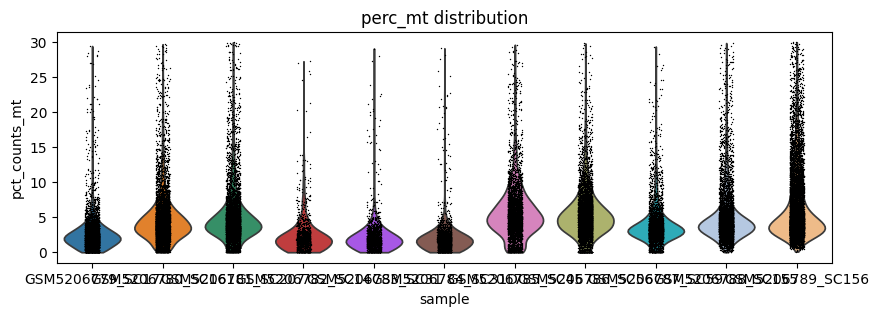

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 3))
sc.pl.violin(query, keys=["pct_counts_mt"], groupby="sample", ax=ax,
             show=False)
plt.title("perc_mt distribution")

### Prediction

### Load model

In [13]:
model = phmap.load_pretrained_model('full_model')

INFO:phmap.core.classifier:Model loaded from /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full.pth
INFO:phmap.core.predictor:Model and metadata loaded from /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full.pth and /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full_metadata.pkl


##### Perform prediction on integrated data

In [14]:
%%time
result = phmap.predict(adata = query, return_probabilities=True)

INFO:phmap.core.classifier:Model loaded from /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full.pth
INFO:phmap.core.predictor:Model and metadata loaded from /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full.pth and /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full_metadata.pkl
INFO:phmap.core.predictor:Loaded default model 'full_model'
INFO:phmap.core.predictor:Prediction completed for 50142 cells


CPU times: user 23.3 s, sys: 4 s, total: 27.3 s
Wall time: 27.3 s


In [15]:
# add prediction to anndata
result.to_adata(query)

AnnData object with n_obs × n_vars = 50142 × 20324
    obs: 'sample', 'group', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'predicted_anno_lv1', 'predicted_anno_lv1_prob', 'predicted_anno_lv2', 'predicted_anno_lv2_prob', 'predicted_anno_lv3', 'predicted_anno_lv3_prob', 'predicted_anno_lv4', 'predicted_anno_lv4_prob'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_colors'
    layers: 'counts'

In [16]:
query.obs.head()

,sample,group,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,...,passing_nUMIs,passing_ngenes,predicted_anno_lv1,predicted_anno_lv1_prob,predicted_anno_lv2,predicted_anno_lv2_prob,predicted_anno_lv3,predicted_anno_lv3_prob,predicted_anno_lv4,predicted_anno_lv4_prob
AAACATACATGTGC-1-GSM5206779_SC17,GSM5206779_SC17,IPAH,GSM5206779_SC17,742,6.610696,1792.0,7.491645,27.008929,49.0,3.912023,...,True,True,Lymphocyte,1.000000,T,0.999997,CD8+ T,0.999664,CD8T_c3_T_GZMH,0.999844
AAACATACGTCTTT-1-GSM5206779_SC17,GSM5206779_SC17,IPAH,GSM5206779_SC17,2164,7.680176,8998.0,9.104869,20.126695,189.0,5.247024,...,True,True,Myeloid,1.000000,DC,1.000000,DC,1.000000,DC_c3_cDC_CD1E,0.963698
AAACATACGTGTCA-1-GSM5206779_SC17,GSM5206779_SC17,IPAH,GSM5206779_SC17,971,6.879356,4021.0,8.299535,36.831634,171.0,5.147494,...,True,True,Myeloid,1.000000,Macrophage,1.000000,Mph alveolar,1.000000,Mph_c6_alveolar_LGALS3,0.994402
AAACATACTGTCCC-1-GSM5206779_SC17,GSM5206779_SC17,IPAH,GSM5206779_SC17,167,5.123964,314.0,5.752573,40.445860,1.0,0.693147,...,True,True,Myeloid,0.999998,Macrophage,0.999995,Mph alveolar,0.999991,Mph_c6_alveolar_LGALS3,0.997681
AAACATTGTTTCGT-1-GSM5206779_SC17,GSM5206779_SC17,IPAH,GSM5206779_SC17,265,5.583496,534.0,6.282267,39.887640,34.0,3.555348,...,True,True,Epithelial,0.994771,Epi AT2,0.997381,Epi AT2,0.998442,Epi_c2_AT2_SFTPC,0.997990


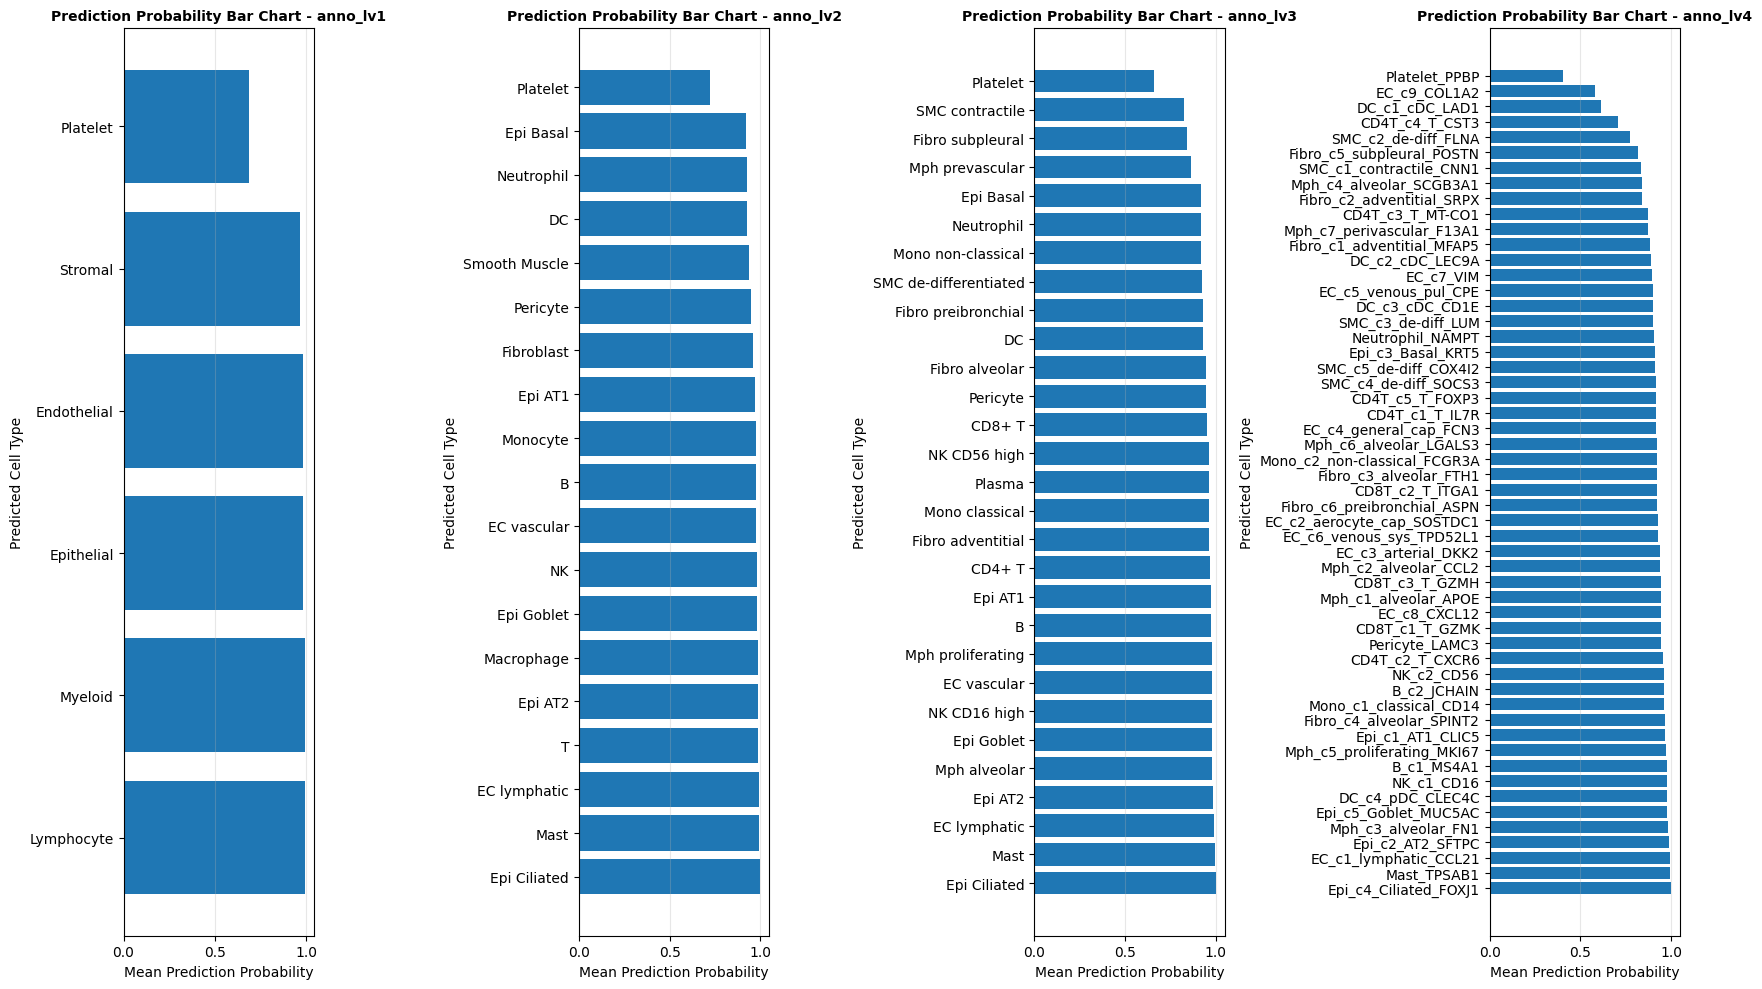

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(17, 10))  # 并排画
for i, label in enumerate(['anno_lv1', 'anno_lv2', 'anno_lv3', 'anno_lv4']):
    phmap.pl.plot_probability_bar(result, label_columns=[label], figsize=(4, 5), orientation='horizontal', ax=axes[i])
plt.tight_layout()
plt.show()

In [30]:
os.makedirs('figures/GSE169471_PC', exist_ok=True)

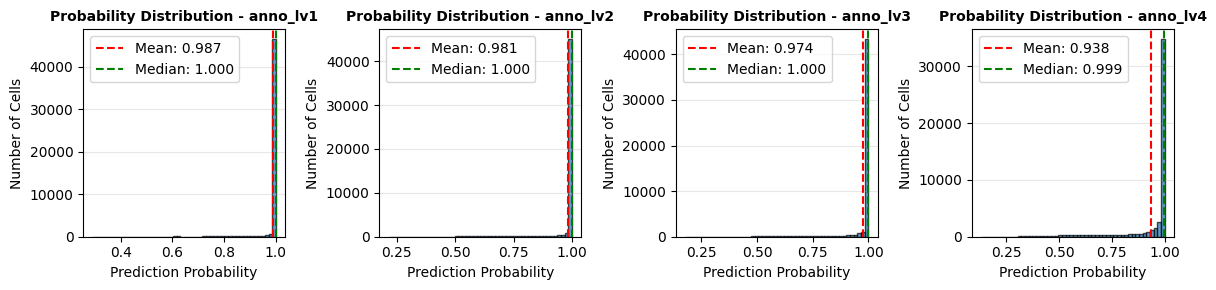

In [31]:
phmap.pl.plot_probability_distribution(result, label_columns=['anno_lv1', 'anno_lv2', 'anno_lv3', 'anno_lv4'], figsize=(3, 3), show=False)
plt.savefig('figures/GSE169471_PC/GSE169471_PC_raw_anno_lv1_2_3_4.pdf', bbox_inches='tight')
plt.show()

### Sankey

In [21]:
query.write_h5ad('data/test_adatas/GSE169471_PC_raw.h5ad', compression='gzip')

... storing 'predicted_anno_lv1' as categorical
... storing 'predicted_anno_lv2' as categorical
... storing 'predicted_anno_lv3' as categorical
... storing 'predicted_anno_lv4' as categorical


In [2]:
query = sc.read_h5ad('data/test_adatas/GSE169471_PC_raw.h5ad')
query

AnnData object with n_obs × n_vars = 50142 × 20324
    obs: 'sample', 'group', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'predicted_anno_lv1', 'predicted_anno_lv1_prob', 'predicted_anno_lv2', 'predicted_anno_lv2_prob', 'predicted_anno_lv3', 'predicted_anno_lv3_prob', 'predicted_anno_lv4', 'predicted_anno_lv4_prob'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_colors'
    layers: 'counts'

In [3]:
annotation_flow_df = query.obs[['predicted_anno_lv1', 'predicted_anno_lv2', 'predicted_anno_lv3', 'predicted_anno_lv4']].drop_duplicates(subset='predicted_anno_lv4').reset_index(drop=True)

In [4]:
def annotation_counter(adata, annotation_col):
    counter = adata.obs[annotation_col].value_counts().to_frame()
    counter['ct'] = counter.index
    counter = counter.reset_index(drop=True)
    counter.columns = ['counts', annotation_col]
    # Convert the column to a categorical dtype before attempting to reorder categories
    counter[annotation_col] = counter[annotation_col].astype('category')
    counter[annotation_col] = counter[annotation_col].cat.reorder_categories(counter[annotation_col].unique().tolist())

    n_clusters = len(counter[annotation_col].cat.categories)
    return(counter, n_clusters)

In [5]:
counter_lv3, n_lv3 = annotation_counter(query, annotation_col = "predicted_anno_lv3")
counter_lv1, n_lv1 = annotation_counter(query, annotation_col = "predicted_anno_lv1")

In [6]:
rank = counter_lv1.iloc[:,1].tolist()
rank

['Myeloid', 'Lymphocyte', 'Endothelial', 'Epithelial', 'Stromal', 'Platelet']

In [7]:
anno_df = (
    query
    .obs[['predicted_anno_lv1','predicted_anno_lv2', 'predicted_anno_lv3',]]
    .drop_duplicates(subset="predicted_anno_lv3", keep='first')
    .reset_index(drop=True)
)
# 合并计数
anno_df = anno_df.merge(counter_lv3, how='inner', on="predicted_anno_lv3")
# Convert 'predicted_anno_lv1' to categorical type before reordering
anno_df['predicted_anno_lv1'] = anno_df['predicted_anno_lv1'].astype('category')
# 按照rank排列
anno_df['predicted_anno_lv1'] = anno_df['predicted_anno_lv1'].cat.reorder_categories(rank, ordered=True)
anno_df.sort_values("predicted_anno_lv1", inplace=True, ascending=True)
# 分群内部按照counts排列
anno_df = (
    anno_df
    .groupby("predicted_anno_lv1")
    .apply(lambda x: x.sort_values("counts", ascending=False))
    .reset_index(drop=True)
)

In [9]:
lv1_cmap = phmap.pl.optim_palette(query, ["predicted_anno_lv1"])
lv1_cmap

{'Endothelial': '#a6cee3',
 'Epithelial': '#b2df8a',
 'Lymphocyte': '#fb9a99',
 'Myeloid': '#ff7f00',
 'Platelet': '#6a3d9a',
 'Stromal': '#b15928'}

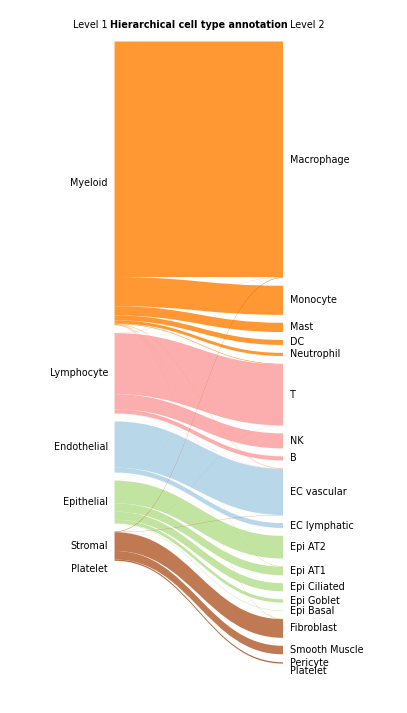

In [ ]:
lv_left = query.obs['predicted_anno_lv1']
lv_right = query.obs['predicted_anno_lv2']
left_order = query.obs['predicted_anno_lv1'].value_counts().index.tolist()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 9))
# plot sankeyy
phmap.pl.sankey(
    x=lv_left,
    y=lv_right,
    title="Hierarchical cell type annotation",
    title_left="Level 1",
    title_right="Level 2",
    ax=ax,
    fontsize="x-small",
    left_order=left_order,
    colors=lv1_cmap,
    alpha=0.8,
)
# fig.savefig("figures/GSE169471_PC/GSE169471_PC_sankey_lv1_lv2.pdf", bbox_inches='tight')
plt.show()
plt.close()

In [16]:
lv2_cmap = phmap.pl.optim_palette(query, ["predicted_anno_lv2"])
lv2_cmap

{'B': '#a6cee3',
 'DC': '#a6cee3',
 'EC lymphatic': '#1f78b4',
 'EC vascular': '#b2df8a',
 'Epi AT1': '#b2df8a',
 'Epi AT2': '#33a02c',
 'Epi Basal': '#fb9a99',
 'Epi Ciliated': '#fb9a99',
 'Epi Goblet': '#e31a1c',
 'Fibroblast': '#fdbf6f',
 'Macrophage': '#fdbf6f',
 'Mast': '#ff7f00',
 'Monocyte': '#cab2d6',
 'NK': '#cab2d6',
 'Neutrophil': '#6a3d9a',
 'Pericyte': '#ffff99',
 'Platelet': '#ffff99',
 'Smooth Muscle': '#b15928',
 'T': '#b15928'}

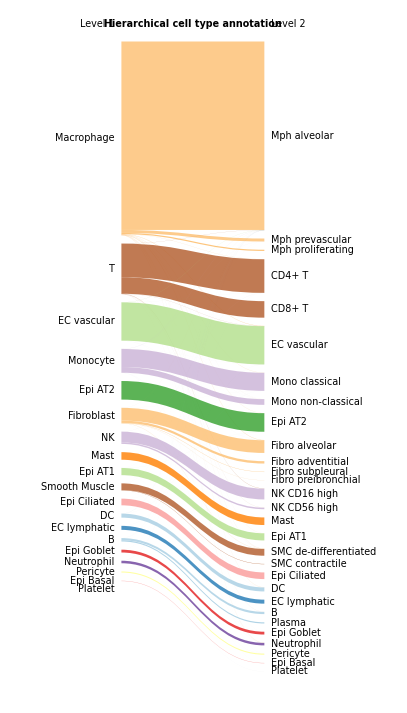

In [ ]:
lv_left = query.obs['predicted_anno_lv2']
lv_right = query.obs['predicted_anno_lv3']
left_order = query.obs['predicted_anno_lv2'].value_counts().index.tolist()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 9))
# plot sankeyy
phmap.pl.sankey(
    x=lv_left,
    y=lv_right,
    title="Hierarchical cell type annotation",
    title_left="Level 1",
    title_right="Level 2",
    ax=ax,
    fontsize="x-small",
    left_order=left_order,
    colors=lv2_cmap,
    alpha=0.8,
)
# fig.savefig("figures/GSE169471_PC/GSE169471_PC_sankey_lv2_lv3.pdf", bbox_inches='tight')
plt.show()
plt.close()

### Integration and visualziation

In [22]:
import scvi
import torch
torch.set_float32_matmul_precision('high')

def find_hvg(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    return adata

def perform_scvi_ref(adata):
    adata_scvi = adata[:, adata.var["highly_variable"]].copy()
    scvi.model.SCVI.setup_anndata(adata_scvi, layer='counts', batch_key='sample')
    scvi_ref = scvi.model.SCVI(
        adata_scvi,
        use_layer_norm="both",
        use_batch_norm="none",
        encode_covariates=True,
        dropout_rate=0.2,
        n_layers=2,
    )
    scvi_ref.train()
    return scvi_ref

def perform_scanvi(adata, scvi_ref):
    adata_scvi = adata[:, adata.var["highly_variable"]].copy()
    scvi.model.SCVI.setup_anndata(adata_scvi, layer='counts', batch_key='sample')
    lvae = scvi.model.SCANVI.from_scvi_model(
        scvi_ref,
        adata=adata_scvi,
        labels_key="predicted_anno_lv3",
        unlabeled_category="Unknown",
    )
    lvae.train(max_epochs=40, n_samples_per_label=20) 
    return lvae

In [23]:
query = find_hvg(query)
scvi_model = perform_scvi_ref(query)
scanvi_model = perform_scanvi(query, scvi_model)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 160/160: 100%|██████████| 160/160 [09:49<00:00,  3.25s/it, v_num=1, train_loss_step=212, train_loss_epoch=206]

INFO: `Trainer.fit` stopped: `max_epochs=160` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=160` reached.


Epoch 160/160: 100%|██████████| 160/160 [09:49<00:00,  3.68s/it, v_num=1, train_loss_step=212, train_loss_epoch=206]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Training for 40 epochs.                                                                                   


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 40/40: 100%|██████████| 40/40 [06:58<00:00, 10.71s/it, v_num=1, train_loss_step=225, train_loss_epoch=203]

INFO: `Trainer.fit` stopped: `max_epochs=40` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [06:58<00:00, 10.47s/it, v_num=1, train_loss_step=225, train_loss_epoch=203]


In [24]:
query.obsm["X_scANVI"] = scanvi_model.get_latent_representation()
sc.pp.neighbors(query, use_rep="X_scANVI", n_neighbors=15)
sc.tl.umap(query)

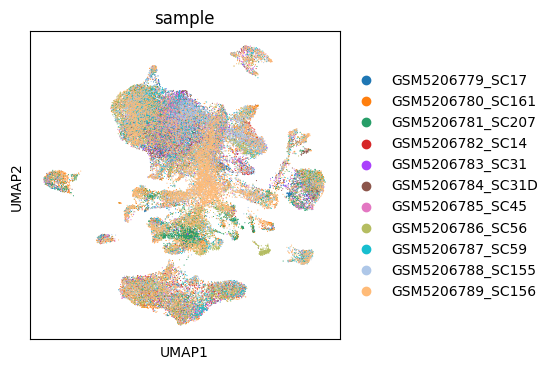

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(query, color=['sample'], ncols=1, ax=ax, show=False)
for ax in fig.axes:
        for collection in ax.collections:
            collection.set_rasterized(True)
# fig.savefig('figures/GSE169471_PC/GSE169471_PC_sample_umap.pdf', bbox_inches='tight', dpi=300)
plt.show()

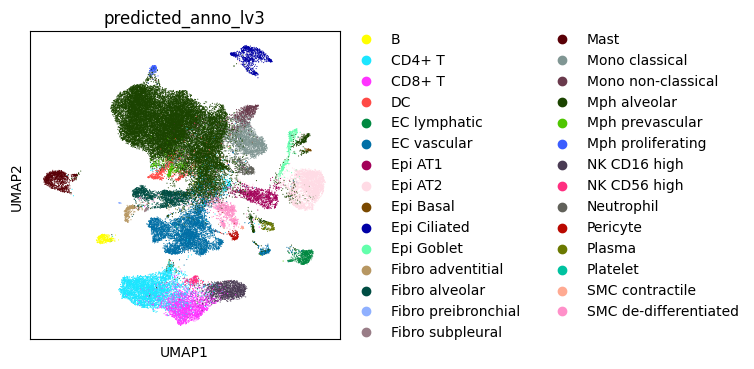

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(query, color=['predicted_anno_lv3'], ncols=1, ax=ax, show=False)
for ax in fig.axes:
        for collection in ax.collections:
            collection.set_rasterized(True)
# fig.savefig('figures/GSE169471_PC/GSE169471_PC_raw_anno_lv3_umap.pdf', bbox_inches='tight', dpi=300)
plt.show()

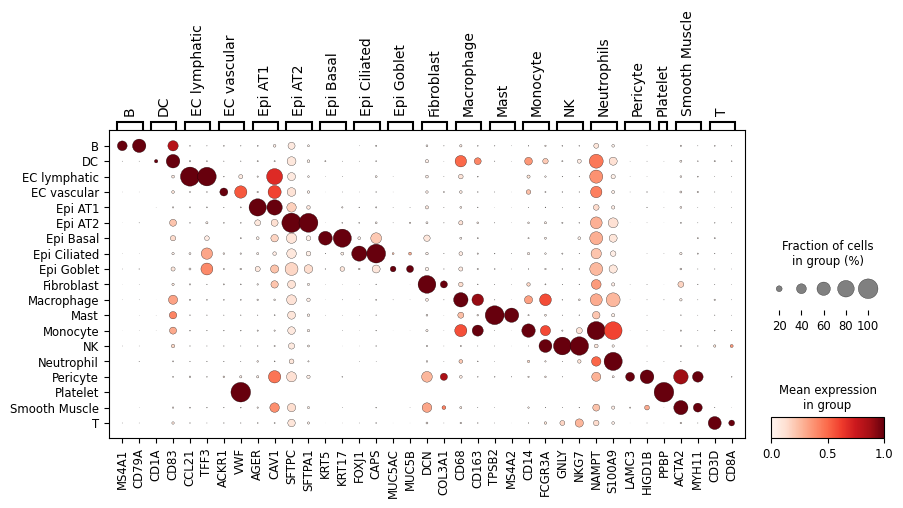

In [ ]:
cell_markers = {
    "B": ["MS4A1", "CD79A"],
    "DC": ["CD1A", "CD83"],
    "EC lymphatic": ["CCL21", "TFF3"],
    "EC vascular": ["ACKR1", "VWF"],
    "Epi AT1": ["AGER", "CAV1"],
    "Epi AT2": ["SFTPC", "SFTPA1"],
    "Epi Basal": ["KRT5", "KRT17"],
    "Epi Ciliated": ["FOXJ1", "CAPS"],
    "Epi Goblet": ["MUC5AC", "MUC5B"],
    "Fibroblast": ["DCN", "COL3A1"],
    "Macrophage": ["CD68", "CD163"],
    "Mast": ["TPSB2", "MS4A2"],
    "Monocyte": ["CD14", "FCGR3A"],
    "NK": ["GNLY", "NKG7"],
    "Neutrophils": ["NAMPT", "S100A9"],   
    "Pericyte": ["LAMC3", "HIGD1B"],
    "Platelet": ["PPBP"],
    "Smooth Muscle": ["ACTA2", "MYH11"],
    "T": ["CD3D","CD8A"],
}
sc.pl.dotplot(
    query, 
    var_names=cell_markers, 
    standard_scale="var", 
    groupby="predicted_anno_lv2", 
    figsize=(10,4),
    show=False
)
# plt.savefig('figures/GSE169471_PC/GSE169471_PC_marker_dotplot.pdf', bbox_inches='tight')
plt.show()